# SOM Project for Seminar "Multimodal Learning"

### Import and settings

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Please change to path to your mml folder on google drive 
#path ="/content/drive/My Drive/mml/"

path ="/content/drive/My Drive/Colab Notebooks/mml/"
path_to_pyera = path + "pyERA-master"

In [4]:
import os
os.chdir(path_to_pyera)
!python setup.py install


/usr/lib/python3.6/distutils/dist.py:261: UserWarning: Unknown distribution option: 'include_package_data'
  warnings.warn(msg)
running install
running build
running build_py
file pyERA.py (for module pyERA) not found
file pyERA.py (for module pyERA) not found
running install_lib
creating /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/__init__.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/utils.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/tfsom.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/hebbian.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/som.py -> /usr/local/lib/python3.6/dist-packages/pyERA
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/__init__.py to __init__.cpython-36.pyc
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/utils.py to utils.cpython-36.pyc
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/tfsom

In [5]:
import numpy as np

#It requires the pyERA library

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pyERA.som import Som
from pyERA.utils import ExponentialDecay
from pyERA.hebbian import HebbianNetwork

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
from PIL import Image
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

os.chdir(path)
from som_functions import testSOM, plotJoints, plotVisual, testSomHubPass, plotSom



In [6]:
def denorm(out):
  mean = np.mean(out)
  std = np.std(out)
  return out*std + mean

### Import dataset

In [7]:
fileNtrain = path + "Nao/database/normalizedDataTrainS.npy"
fileNtest = path + "Nao/database/normalizedDataTest.npy"
filePtest = path + "Nao/database/preprocessedDataTest.npy"

In [8]:
sampleLen = 8196
N_test = 100
N_train = 2000
raw_train = np.load(fileNtrain)
raw_train = raw_train.reshape(N_train, sampleLen)
train_joints = raw_train[:, 1:4].astype(float)
train_topCam = raw_train[:, 4:4100].astype(np.uint8)
train_botCam = raw_train[:, 4100:].astype(np.uint8)

raw_test = np.load(fileNtest)
raw_test = raw_test.reshape(N_test, sampleLen)
test_joints = raw_test[:, 1:4].astype(float)
test_topCam = raw_test[:, 4:4100] #.astype(np.uint8)
test_botCam = raw_test[:, 4100:]  #.astype(np.uint8)

raw_test = np.load(filePtest)
raw_test = raw_test.reshape(N_test, sampleLen)
test_jointsP = raw_test[:, 1:4].astype(float)
test_topCamP = raw_test[:, 4:4100] #.astype(np.uint8)
test_botCamP = raw_test[:, 4100:]  #.astype(np.uint8)

tot_sample = N_train

### How to build and train SOM with PyERA
Version 1: Connect Proprioceptive SOM and SOM of bottom Camera directly 

##### Create SOM Architecture

In [9]:
som_size = 30
visual_som = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
proprio_som = Som(matrix_size=som_size, input_size= len(train_joints[1]))

hebbian_network = HebbianNetwork("net")
hebbian_network.add_node("visual_som", (som_size, som_size))
hebbian_network.add_node("proprio_som", (som_size, som_size))
hebbian_network.add_connection(0, 1)

hebbian_network.print_info()


Net Name ..... net
Total Nodes ..... 2
Total Connections ..... 1
Nodes Name: 
visual_som;
proprio_som;



#### Train Network

In [10]:
tot_epoch = 1
my_learning_rate = ExponentialDecay(starter_value=0.5, decay_step=tot_epoch * tot_sample/ 5, decay_rate=0.9, staircase=True)
my_radius = ExponentialDecay(starter_value=np.rint(som_size / 3), decay_step=tot_epoch * tot_sample/ 6, decay_rate=0.90,
							 staircase=True)

tot_sample =100
print("Training starts.")
for epoch in range(1, tot_epoch+1):
	for sample in range(1, tot_sample):

		learning_rate = my_learning_rate.return_decayed_value(global_step=epoch * tot_sample + sample)
		radius = my_radius.return_decayed_value(global_step=epoch * tot_sample + sample)

		# Training the Visual SOM
		input_vector = train_topCam[sample]
		bmu_index = visual_som.return_BMU_index(input_vector)
		bmu_weights = visual_som.get_unit_weights(bmu_index[0], bmu_index[1])
		bmu_neighborhood_list = visual_som.return_unit_round_neighborhood(bmu_index[0], bmu_index[1], radius=radius)
		visual_activation_matrix = visual_som.return_activation_matrix(input_vector)
		visual_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)

		# Training the Proprioceptive SOM
		input_vector = train_joints[sample]
		bmu_index = proprio_som.return_BMU_index(input_vector)
		bmu_weights = proprio_som.get_unit_weights(bmu_index[0], bmu_index[1])
		bmu_neighborhood_list = proprio_som.return_unit_round_neighborhood(bmu_index[0], bmu_index[1], radius=radius)
		proprio_activation_matrix = proprio_som.return_activation_matrix(input_vector)
		proprio_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)

		# Hebbian Learning
		hebbian_network.set_node_activations(0, visual_activation_matrix)
		hebbian_network.set_node_activations(1, proprio_activation_matrix)
		hebbian_network.learning(learning_rate=0.1, rule="hebb")

print("Training is done.")

Training starts.
Training is done.


#### Test

 ##### Recreate joint data from visual data

Joints from visual data
mse: 0.12592377172107772
std: 0.0599752723473245


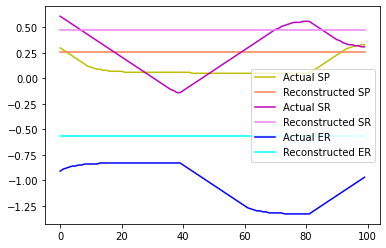

In [11]:
out_91, mse_mean_91, mse_std_91 = testSOM(visual_som, proprio_som, 0, 1, hebbian_network, N_test, test_botCam, test_joints)
print('Joints from visual data')
print('mse:', mse_mean_91)
print('std:', mse_std_91)
plotJoints(test_joints, out_91)

##### Recreate visual data from joint data

In [12]:
out_92, mse_mean_92, mse_std_92 = testSOM(proprio_som, visual_som, 1, 0, hebbian_network, N_test, test_joints, test_botCam)
print('Visual data from joints')
print('mse:', mse_mean_92)
print('std:', mse_std_92)

Visual data from joints
mse: 20.96961918891111
std: 20.279192316190873


Visualisation

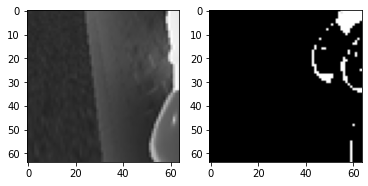

In [13]:
sampleNummer=50
out_92 = out_92*1000
plotVisual(test_topCamP, out_92, sampleNummer)
sampleNummer+=1


##  Version 0: Proprio SOM used as Hub SOM

In [14]:

som_size = 30
top_visual_som_0 = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_0 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_0= Som(matrix_size=som_size, input_size= len(train_joints[1]))


hebbian_network_0 = HebbianNetwork("net_0")
hebbian_network_0.add_node("top_visual_som_0", (som_size, som_size))
hebbian_network_0.add_node("bottom_visual_som_0", (som_size, som_size))
hebbian_network_0.add_node("proprio_som_0", (som_size, som_size))
hebbian_network_0.add_connection(0, 2)
hebbian_network_0.add_connection(1, 2)

hebbian_network_0.print_info()


Net Name ..... net_0
Total Nodes ..... 3
Total Connections ..... 2
Nodes Name: 
top_visual_som_0;
bottom_visual_som_0;
proprio_som_0;



In [15]:
bottom_visual_som_0.load(path + "training_data/soms/proprio_hub/bottom_visual_som_0.npz")
top_visual_som_0.load(path + "training_data/soms/proprio_hub/top_visual_som_0.npz")
proprio_som_0.load(path + "training_data/soms/proprio_hub/proprio_som_0.npz")
for connection in hebbian_network_0._connection_list:
    npzfile = np.load(path + "training_data/soms/proprio_hub/connection0" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']

#### Visualizing SOMs Activations map

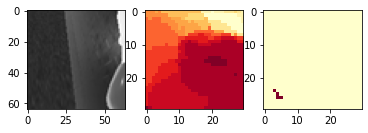

In [16]:
sample_n = 50
plotSom(test_topCamP, sample_n, top_visual_som_0)

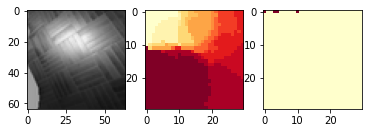

In [17]:
plotSom(test_botCamP, sample_n, bottom_visual_som_0)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.2074363256552209
std: 0.12742669951266955


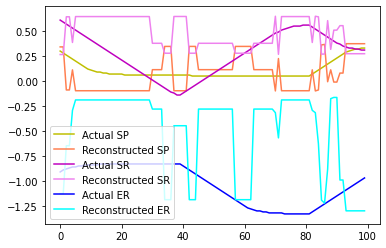

In [18]:
out_01, mse_mean_01, mse_std_01 = testSOM(bottom_visual_som_0, proprio_som_0, 1, 2, hebbian_network_0, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_01)
print('std:', mse_std_01)
plotJoints(test_joints, out_01)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.19913315811542695
std: 0.14016832796873036


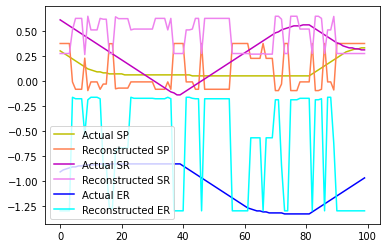

In [19]:
out_02, mse_mean_02, mse_std_02 = testSOM(top_visual_som_0, proprio_som_0, 0, 2, hebbian_network_0, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_02)
print('std:', mse_std_02)
plotJoints(test_joints, out_02)

#### Recreate bottom visual data from joint data

In [20]:
out_03, mse_mean_03, mse_std_03 = testSOM(proprio_som_0, bottom_visual_som_0, 2, 1, hebbian_network_0, N_test, test_joints, test_botCam)
print('Joints from bottom camera data')
print('mse:', mse_mean_03)
print('std:', mse_std_03)

Joints from bottom camera data
mse: 2990.435477816939
std: 564.7475514485558


Visualisation

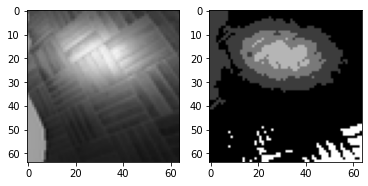

In [21]:
sampleNummer=50
out_03 = denorm(out_03)
plotVisual(test_botCamP, out_03, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [22]:
out_04, mse_mean_04, mse_std_04 = testSOM(proprio_som_0, top_visual_som_0, 2, 0, hebbian_network_0, N_test, test_joints, test_topCam)
print('Top camera data from joints')
print('mse:', mse_mean_04)
print('std:', mse_std_04)


Top camera data from joints
mse: 0.8755018732381243
std: 0.31219728393887314


Visialisation



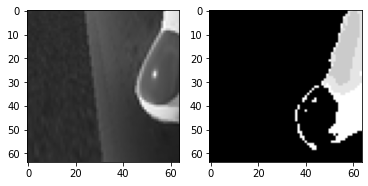

In [23]:
sampleNummer=75
out_04 = out_04*1000
plotVisual(test_topCamP, out_04, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [24]:
out_05, mse_mean_05, mse_std_05 = testSomHubPass(bottom_visual_som_0, proprio_som_0,  top_visual_som_0, 0, 2, 1, hebbian_network_0, N_test, test_botCam, test_topCam)
print('Top camera data from bottom')
print('mse:', mse_mean_05)
print('std:', mse_std_05)

Top camera data from bottom
mse: 1.029711114141431
std: 0.4277157302255429


Visualisation

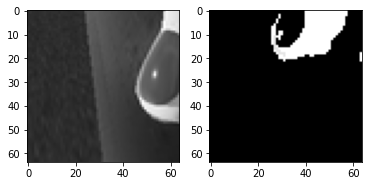

In [25]:
sampleNummer=75
out_05 = out_05*1000
plotVisual(test_topCamP, out_05, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [26]:
out_06, mse_mean_06, mse_std_06 = testSomHubPass(top_visual_som_0, proprio_som_0,  bottom_visual_som_0, 1, 2, 0, hebbian_network_0, N_test, test_topCam, test_botCam)
print('Bottom camera from top camera data')
print('mse:', mse_mean_06)
print('std:', mse_std_06)


Bottom camera from top camera data
mse: 1891.3122704289597
std: 0.14132883590045872


Visualisation

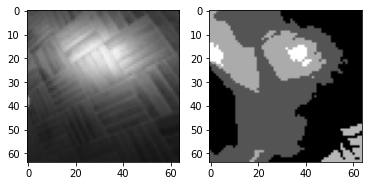

In [27]:
sampleNummer=75
out_06 = denorm(out_06)
plotVisual(test_botCamP, out_06, sampleNummer)
sampleNummer+=1

## Version 1 : Extra Hub Som

In [28]:
som_size = 30
top_visual_som_1 = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_1 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_1 = Som(matrix_size=som_size, input_size= len(train_joints[1]))
hub_som_1 = Som(matrix_size=som_size, input_size=6)

In [29]:
hebbian_network_1 = HebbianNetwork("net_1")
hebbian_network_1.add_node("hub_som_1", (som_size, som_size))
hebbian_network_1.add_node("top_visual_som_1", (som_size, som_size))
hebbian_network_1.add_node("bottom_visual_som_1", (som_size, som_size))
hebbian_network_1.add_node("proprio_som_1", (som_size, som_size))
hebbian_network_1.add_connection(1, 0)
hebbian_network_1.add_connection(2, 0)
hebbian_network_1.add_connection(3, 0)

hebbian_network_1.print_info()


Net Name ..... net_1
Total Nodes ..... 4
Total Connections ..... 3
Nodes Name: 
hub_som_1;
top_visual_som_1;
bottom_visual_som_1;
proprio_som_1;



In [30]:
bottom_visual_som_1.load(path + "training_data/soms/hub_node/bottom_visual_som_1.npz")
top_visual_som_1.load(path + "training_data/soms/hub_node/top_visual_som_1.npz")
proprio_som_1.load(path + "training_data/soms/hub_node/proprio_som_1.npz")
hub_som_1.load(path + "training_data/soms/hub_node/hub_som_1.npz")
for connection in hebbian_network_1._connection_list:
    npzfile = np.load(path + "training_data/soms/hub_node/connection1" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']


#### Visualizing SOMs Activations map

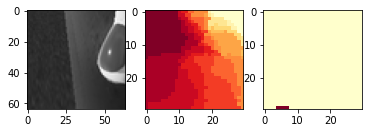

In [31]:
sample_n = 75
plotSom(test_topCamP, sample_n, top_visual_som_1)

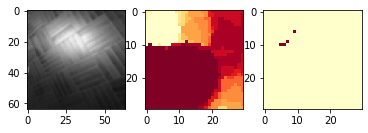

In [32]:
plotSom(test_botCamP, sample_n, bottom_visual_som_1)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.28129710356755644
std: 0.15131825597031623


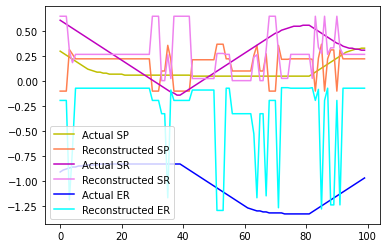

In [33]:
out_11, mse_mean_11, mse_std_11 = testSomHubPass(bottom_visual_som_1, hub_som_1, proprio_som_1, 2, 0, 3, hebbian_network_1, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_11)
print('std:', mse_std_11)
plotJoints(test_joints, out_11)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.234537554443697
std: 0.15555310156292795


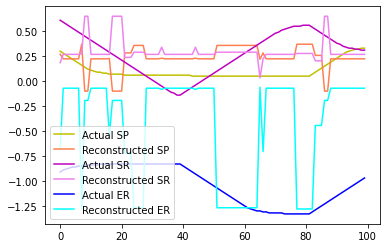

In [34]:
out_12, mse_mean_12, mse_std_12 = testSomHubPass(top_visual_som_1, hub_som_1, proprio_som_1, 1, 0, 3, hebbian_network_1, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_12)
print('std:', mse_std_12)
plotJoints(test_joints, out_12)

#### Recreate bottom visual data from joint data

In [35]:
out_13, mse_mean_13, mse_std_13 = testSomHubPass(proprio_som_1, hub_som_1, bottom_visual_som_1, 3, 0, 2, hebbian_network_1, N_test, test_joints, test_botCam)
print('Joints from bottom camera data')
print('mse:', mse_mean_13)
print('std:', mse_std_13)

Joints from bottom camera data
mse: 3269.429443165377
std: 138.53248327223807


Visualisation

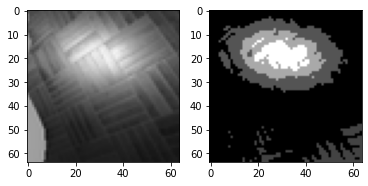

In [36]:
sampleNummer=50
out_13 = denorm(out_13)
plotVisual(test_botCamP, out_13, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [37]:
out_14, mse_mean_14, mse_std_14 = testSomHubPass(proprio_som_1, hub_som_1, top_visual_som_1, 3, 0, 1, hebbian_network_1, N_test, test_joints, test_topCam)
print('Top camera data from joints')
print('mse:', mse_mean_14)
print('std:', mse_std_14)

Top camera data from joints
mse: 0.999623727929634
std: 0.40928147564657597


Visialisation



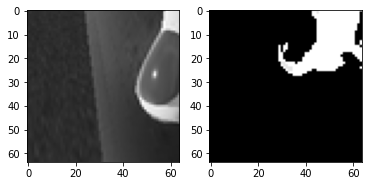

In [38]:
sampleNummer=75
out_14 = out_14 *1000
plotVisual(test_topCamP, out_14, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [39]:
out_15, mse_mean_15, mse_std_15 = testSomHubPass(bottom_visual_som_1, hub_som_1,  top_visual_som_1, 2, 0, 1, hebbian_network_1, N_test, test_botCam, test_topCam)
print('Top camera from bottom camera data')
print('mse:', mse_mean_15)
print('std:', mse_std_15)

Top camera from bottom camera data
mse: 0.9726207318689386
std: 0.4178187383742549


Visualisation

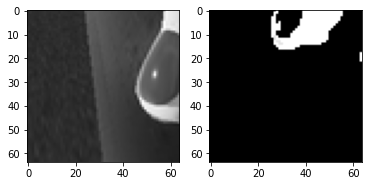

In [40]:
sampleNummer=75
out_15 = out_15*1000
plotVisual(test_topCamP, out_15, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [41]:
out_16, mse_mean_16, mse_std_16 = testSomHubPass(top_visual_som_1, hub_som_1,  bottom_visual_som_1, 1, 0, 2, hebbian_network_1, N_test, test_topCam, test_botCam)
print('Bottom camera from top camera data')
print('mse:', mse_mean_16)
print('std:', mse_std_16)


Bottom camera from top camera data
mse: 2743.744965664703
std: 652.4985736844101


Visualisation

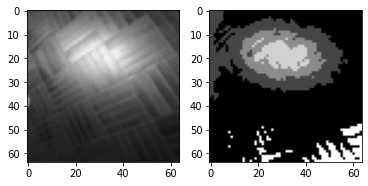

In [42]:
sampleNummer=75
out_16 = denorm(out_16)
plotVisual(test_botCamP, out_16, sampleNummer)
sampleNummer+=1

## Version 2 : Extra Hub Som on concatenated data

In [43]:
som_size = 30
top_visual_som_2 = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_2 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_2 = Som(matrix_size=som_size, input_size= len(train_joints[1]))
hub_som_2 = Som(matrix_size=som_size, input_size=len(train_botCam[0])+len(train_topCam[0])+len(train_joints[1]))


hebbian_network_2 = HebbianNetwork("net_2")
hebbian_network_2.add_node("hub_som_2", (som_size, som_size))
hebbian_network_2.add_node("top_visual_som_2", (som_size, som_size))
hebbian_network_2.add_node("bottom_visual_som_2", (som_size, som_size))
hebbian_network_2.add_node("proprio_som_2", (som_size, som_size))
hebbian_network_2.add_connection(1, 0)
hebbian_network_2.add_connection(2, 0)
hebbian_network_2.add_connection(3, 0)

hebbian_network_2.print_info()



Net Name ..... net_2
Total Nodes ..... 4
Total Connections ..... 3
Nodes Name: 
hub_som_2;
top_visual_som_2;
bottom_visual_som_2;
proprio_som_2;



In [44]:
bottom_visual_som_2.load(path + "training_data/soms/hub_concat/bottom_visual_som_2.npz")
top_visual_som_2.load(path + "training_data/soms/hub_concat/top_visual_som_2.npz")
proprio_som_2.load(path + "training_data/soms/hub_concat/proprio_som_2.npz")
hub_som_2.load(path + "training_data/soms/hub_concat/hub_som_2.npz")
for connection in hebbian_network_2._connection_list:
    npzfile = np.load(path + "training_data/soms/hub_concat/connection2" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']

#### Visualizing SOMs Activations map

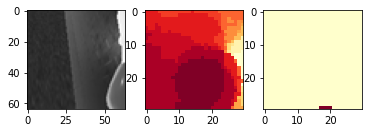

In [45]:
sample_n = 50
plotSom(test_topCamP, sample_n, top_visual_som_2)

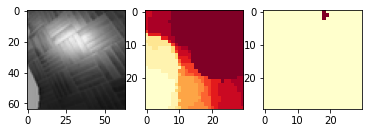

In [46]:
plotSom(test_botCamP, sample_n, bottom_visual_som_2)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.1526679474580586
std: 0.12567229225583298


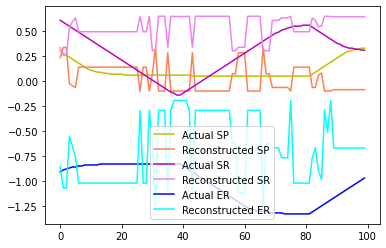

In [47]:
out_21, mse_mean_21, mse_std_21 = testSomHubPass(bottom_visual_som_2, hub_som_2, proprio_som_2, 2, 0, 3, hebbian_network_2, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_21)
print('std:', mse_std_21)
plotJoints(test_joints, out_21)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.10552983138356478
std: 0.062400748172034774


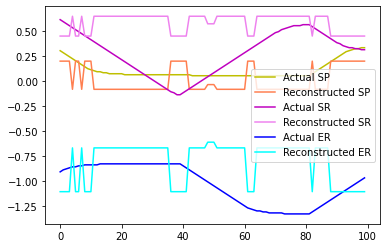

In [48]:
out_22, mse_mean_22, mse_std_22 = testSomHubPass(top_visual_som_2, hub_som_2, proprio_som_2, 1, 0, 3, hebbian_network_2, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_22)
print('std:', mse_std_22)
plotJoints(test_joints, out_22)

#### Recreate bottom visual data from joint data

In [49]:
out_23, mse_mean_23, mse_std_23 = testSomHubPass(proprio_som_2, hub_som_2, bottom_visual_som_2, 3, 0, 2, hebbian_network_2, N_test, test_joints, test_botCam)
print('Bottom camera data from joints')
print('mse:', mse_mean_23)
print('std:', mse_std_23)

Bottom camera data from joints
mse: 1998.443537908654
std: 21.92812193587854


Visualisation

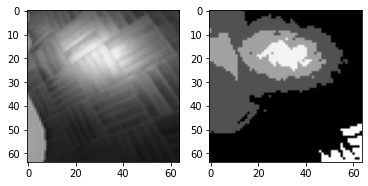

In [50]:
sampleNummer=50
out_23 = denorm(out_23)
plotVisual(test_botCamP, out_23, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [51]:
out_24, mse_mean_24, mse_std_24 = testSomHubPass(proprio_som_2, hub_som_2, top_visual_som_2, 3, 0, 1, hebbian_network_2, N_test, test_joints, test_topCam)
print('top camera data from joints')
print('mse:', mse_mean_24)
print('std:', mse_std_24)


top camera data from joints
mse: 1.0144423352554544
std: 0.4286739700643818


Visialisation



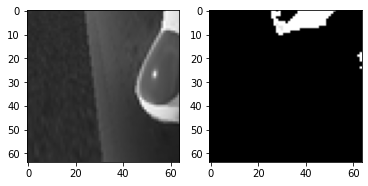

In [52]:
sampleNummer=75
out_24 = out_24*1000
plotVisual(test_topCamP, out_24, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [53]:
out_25, mse_mean_25, mse_std_25 = testSomHubPass(bottom_visual_som_2, hub_som_2,  top_visual_som_2, 2, 0, 1, hebbian_network_2, N_test, test_botCam, test_topCam)
print('top camera data from bottom')
print('mse:', mse_mean_25)
print('std:', mse_std_25)

top camera data from bottom
mse: 1.031643995825404
std: 0.43171661109463044


Visualisation

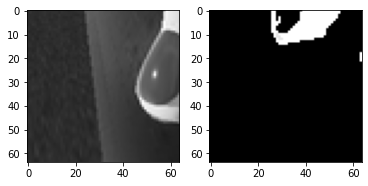

In [54]:
sampleNummer=75
out_25 = out_25*1000
plotVisual(test_topCamP, out_25, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [55]:
out_26, mse_mean_26, mse_std_26 = testSomHubPass(top_visual_som_2, hub_som_2,  bottom_visual_som_2, 1, 0, 2, hebbian_network_2, N_test, test_topCam, test_botCam)
print('Bottom camera from top camera data')
print('mse:', mse_mean_26)
print('std:', mse_std_26)


Bottom camera from top camera data
mse: 2041.794014929906
std: 221.17903873540635


Visualisation

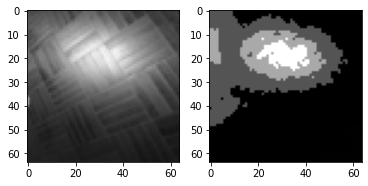

In [56]:
sampleNummer=75
out_26 = denorm(out_26)
plotVisual(test_botCamP, out_26, sampleNummer)
sampleNummer+=1

##  Version 3: Proprio Hub SOM trained with Cosine Similarity
Using proprio SOM as Hub

In [57]:

som_size = 30
top_visual_som_3 = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_3 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_3= Som(matrix_size=som_size, input_size= len(train_joints[1]))


hebbian_network_3 = HebbianNetwork("net_3")
hebbian_network_3.add_node("top_visual_som_3", (som_size, som_size))
hebbian_network_3.add_node("bottom_visual_som_3", (som_size, som_size))
hebbian_network_3.add_node("proprio_som_3", (som_size, som_size))
hebbian_network_3.add_connection(0, 2)
hebbian_network_3.add_connection(1, 2)

hebbian_network_3.print_info()


Net Name ..... net_3
Total Nodes ..... 3
Total Connections ..... 2
Nodes Name: 
top_visual_som_3;
bottom_visual_som_3;
proprio_som_3;



In [58]:
bottom_visual_som_3.load(path + "training_data/soms/with_cosine_similarity/bottom_visual_som_cosine_propriohub.npz")
top_visual_som_3.load(path + "training_data/soms/with_cosine_similarity/top_visual_som_cosine_propriohub.npz")
proprio_som_3.load(path + "training_data/soms/with_cosine_similarity/proprio_som_cosine_propriohub.npz")
for connection in hebbian_network_3._connection_list:
    npzfile = np.load(path + "training_data/soms/with_cosine_similarity/connection_cosine_propriohub" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']
    

#### Visualizing SOMs Activations map

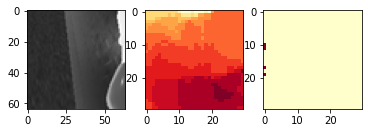

In [59]:
sample_n = 50
plotSom(test_topCamP, sample_n, top_visual_som_3)

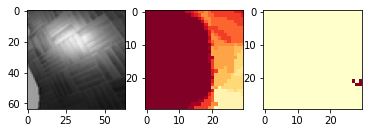

In [60]:
plotSom(test_botCamP, sample_n, bottom_visual_som_3)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.11278264653106851
std: 0.08142684557529448


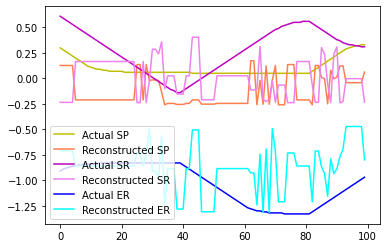

In [61]:
out_31, mse_mean_31, mse_std_31 = testSOM(bottom_visual_som_3, proprio_som_3, 1, 2, hebbian_network_3, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_31)
print('std:', mse_std_31)
plotJoints(test_joints, out_31)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.07341486625310964
std: 0.09358229433103875


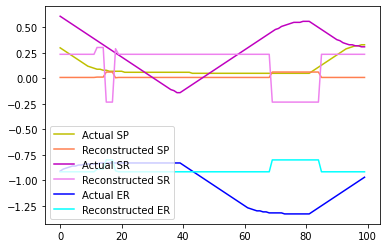

In [62]:
out_32, mse_mean_32, mse_std_32 = testSOM(top_visual_som_3, proprio_som_3, 0, 2, hebbian_network_3, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_32)
print('std:', mse_std_32)
plotJoints(test_joints, out_32)

#### Recreate bottom visual data from joint data

In [63]:
out_33, mse_mean_33, mse_std_33 = testSOM(proprio_som_3, bottom_visual_som_3, 2, 1, hebbian_network_3, N_test, test_joints, test_botCam)
print('bottom camera data from joints')
print('mse:', mse_mean_33)
print('std:', mse_std_33)

bottom camera data from joints
mse: 2560.4841566181262
std: 1160.7493881646412


Visualisation

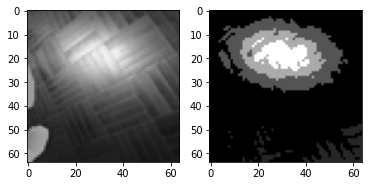

In [64]:
sampleNummer=64
out_33 = denorm(out_33)
plotVisual(test_botCamP, out_33, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [65]:
out_34, mse_mean_34, mse_std_34 = testSOM(proprio_som_3, top_visual_som_3, 2, 0, hebbian_network_3, N_test, test_joints, test_topCam)
print('top camera data from joints')
print('mse:', mse_mean_34)
print('std:', mse_std_34)


top camera data from joints
mse: 1.0713368609597886
std: 0.34650579290919814


Visialisation



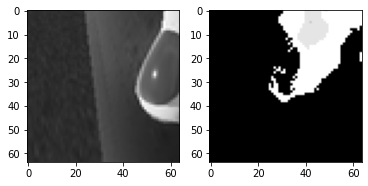

In [66]:
sampleNummer=75
out_34 = out_34*1000
plotVisual(test_topCamP, out_34, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [67]:
out_35, mse_mean_35, mse_std_35 = testSomHubPass(bottom_visual_som_3, proprio_som_3,  top_visual_som_3, 0, 2, 1, hebbian_network_3, N_test, test_botCam, test_topCam)
print('Top camera data from bottom')
print('mse:', mse_mean_35)
print('std:', mse_std_35)

Top camera data from bottom
mse: 1.1491196331066411
std: 0.4293202893686155


Visualisation

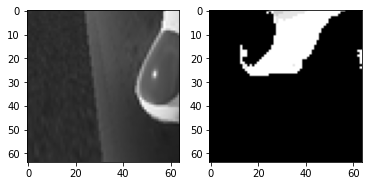

In [68]:
sampleNummer=75
out_35 = out_35*1000
plotVisual(test_topCamP, out_35, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [69]:
out_36, mse_mean_36, mse_std_36 = testSomHubPass(top_visual_som_3, proprio_som_3,  bottom_visual_som_3, 1, 2, 0, hebbian_network_3, N_test, test_topCam, test_botCam)
print('Bot from top camera data')
print('mse:', mse_mean_36)
print('std:', mse_std_36)


Bot from top camera data
mse: 398.6388253142366
std: 534.9029629228609


Visualisation

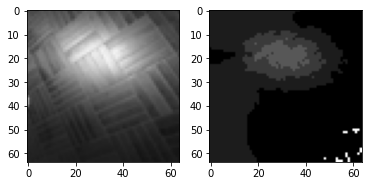

In [70]:
sampleNummer=75
out_36 = denorm(out_36)
plotVisual(test_botCamP, out_36, sampleNummer)
sampleNummer+=1

## Version 4 : Extra Hub Som trained with Cosine Similarity

In [71]:
som_size = 30
top_visual_som_4 = Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_4 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_4 = Som(matrix_size=som_size, input_size= len(train_joints[1]))
hub_som_4 = Som(matrix_size=som_size, input_size=6)

In [72]:
hebbian_network_4 = HebbianNetwork("net_4")
hebbian_network_4.add_node("hub_som_4", (som_size, som_size))
hebbian_network_4.add_node("top_visual_som_4", (som_size, som_size))
hebbian_network_4.add_node("bottom_visual_som_4", (som_size, som_size))
hebbian_network_4.add_node("proprio_som_4", (som_size, som_size))
hebbian_network_4.add_connection(1, 0)
hebbian_network_4.add_connection(2, 0)
hebbian_network_4.add_connection(3, 0)

hebbian_network_4.print_info()


Net Name ..... net_4
Total Nodes ..... 4
Total Connections ..... 3
Nodes Name: 
hub_som_4;
top_visual_som_4;
bottom_visual_som_4;
proprio_som_4;



In [73]:
bottom_visual_som_4.load(path + "training_data/soms/with_cosine_similarity/bottom_visual_som_cosine_nodehub.npz")
top_visual_som_4.load(path + "training_data/soms/with_cosine_similarity/top_visual_som_cosine_nodehub.npz")
proprio_som_4.load(path + "training_data/soms/with_cosine_similarity/proprio_som_cosine_nodehub.npz")
hub_som_4.load(path + "training_data/soms/with_cosine_similarity/hub_som_cosine_nodehub.npz")
for connection in hebbian_network_4._connection_list:
    npzfile = np.load(path + "training_data/soms/with_cosine_similarity/connection_cosine_nodehub" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']
    

#### Visualizing SOMs Activations map

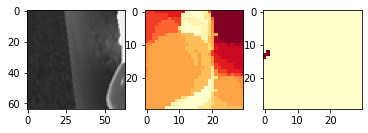

In [74]:
sample_n = 50
plotSom(test_topCamP, sample_n, top_visual_som_4)

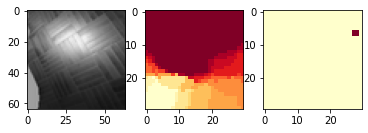

In [75]:
plotSom(test_botCamP, sample_n, bottom_visual_som_4)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.0949701882916467
std: 0.055957095631801464


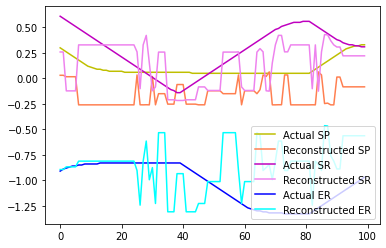

In [76]:
out_41, mse_mean_41, mse_std_41 = testSomHubPass(bottom_visual_som_4, hub_som_4, proprio_som_4, 2, 0, 3, hebbian_network_4, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_41)
print('std:', mse_std_41)
plotJoints(test_joints, out_41)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.09707363436982504
std: 0.06714347009354599


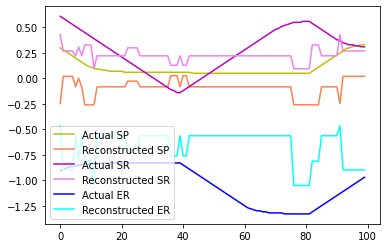

In [77]:
out_42, mse_mean_42, mse_std_42 = testSomHubPass(top_visual_som_4, hub_som_4, proprio_som_4, 1, 0, 3, hebbian_network_4, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_42)
print('std:', mse_std_42)
plotJoints(test_joints, out_42)

#### Recreate bottom visual data from joint data

In [78]:
out_43, mse_mean_43, mse_std_43 = testSomHubPass(proprio_som_4, hub_som_4, bottom_visual_som_4, 3, 0, 2, hebbian_network_4, N_test, test_joints, test_botCam)
print('bottom camera data from joints')
print('mse:', mse_mean_43)
print('std:', mse_std_43)

bottom camera data from joints
mse: 953.9213288791667
std: 1462.4476093507578


Visualisation

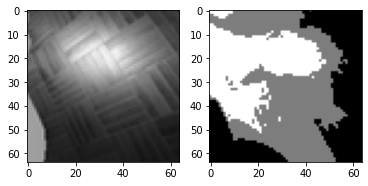

In [79]:
sampleNummer=50
out_43 = denorm(out_43)
plotVisual(test_botCamP, out_43, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [80]:
out_44, mse_mean_44, mse_std_44 = testSomHubPass(proprio_som_4, hub_som_4, top_visual_som_4, 3, 0, 1, hebbian_network_4, N_test, test_joints, test_topCam)
print('top camera data from joints')
print('mse:', mse_mean_44)
print('std:', mse_std_44)


top camera data from joints
mse: 0.9969129279157062
std: 0.4144155825368826


Visialisation



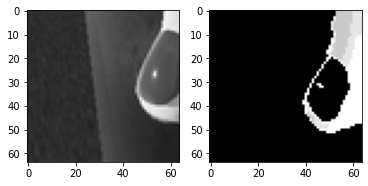

In [81]:
sampleNummer=75
out_44 = out_44*1000
plotVisual(test_topCamP, out_44, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [82]:
out_45, mse_mean_45, mse_std_45 = testSomHubPass(bottom_visual_som_4, hub_som_4,  top_visual_som_4, 2, 0, 1, hebbian_network_4, N_test, test_botCam, test_topCam)
print('top camera data from bottom')
print('mse:', mse_mean_45)
print('std:', mse_std_45)

top camera data from bottom
mse: 0.9550971211348849
std: 0.41432076078250857


Visualisation

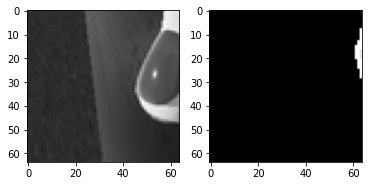

In [83]:
sampleNummer=75
out_45 = out_45*1000
plotVisual(test_topCamP, out_45, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [84]:
out_46, mse_mean_46, mse_std_46 = testSomHubPass(top_visual_som_4, hub_som_4,  bottom_visual_som_4, 1, 0, 2, hebbian_network_4, N_test, test_topCam, test_botCam)
print('Bottom from top camera data')
print('mse:', mse_mean_46)
print('std:', mse_std_46)


Bottom from top camera data
mse: 1.9311295855317103
std: 0.12882590748835018


Visualisation

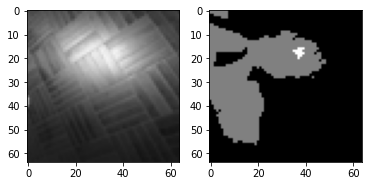

In [85]:
sampleNummer=75
out_46 = denorm(out_46)
plotVisual(test_botCamP, out_46, sampleNummer)
sampleNummer+=1


## Version 5 : Extra Hub Som on concatenated data trained with Cosine Similarity

In [86]:
som_size = 30
top_visual_som_5= Som(matrix_size=som_size, input_size= len(train_topCam[0]))
bottom_visual_som_5 = Som(matrix_size=som_size, input_size= len(train_botCam[0]))
proprio_som_5 = Som(matrix_size=som_size, input_size= len(train_joints[1]))
hub_som_5 = Som(matrix_size=som_size, input_size=len(train_botCam[0])+len(train_topCam[0])+len(train_joints[1]))


hebbian_network_5 = HebbianNetwork("net_5")
hebbian_network_5.add_node("hub_som_5", (som_size, som_size))
hebbian_network_5.add_node("top_visual_som_5", (som_size, som_size))
hebbian_network_5.add_node("bottom_visual_som_5", (som_size, som_size))
hebbian_network_5.add_node("proprio_som_5", (som_size, som_size))
hebbian_network_5.add_connection(1, 0)
hebbian_network_5.add_connection(2, 0)
hebbian_network_5.add_connection(3, 0)

hebbian_network_5.print_info()



Net Name ..... net_5
Total Nodes ..... 4
Total Connections ..... 3
Nodes Name: 
hub_som_5;
top_visual_som_5;
bottom_visual_som_5;
proprio_som_5;



In [87]:
bottom_visual_som_5.load(path + "training_data/soms/with_cosine_similarity/bottom_visual_som_cosine_concathub.npz")
top_visual_som_5.load(path + "training_data/soms/with_cosine_similarity/top_visual_som_cosine_concathub.npz")
proprio_som_5.load(path + "training_data/soms/with_cosine_similarity/proprio_som_cosine_concathub.npz")
hub_som_5.load(path + "training_data/soms/with_cosine_similarity/hub_som_cosine_concathub.npz")
for connection in hebbian_network_5._connection_list:
    npzfile = np.load(path + "training_data/soms/with_cosine_similarity/connection_cosine_concathub" + str(connection["Start"]) + str(connection["End"]) + ".npz")
    connection["Connection"]._weights_matrix = npzfile['arr_0']

#### Visualizing SOMs Activations map

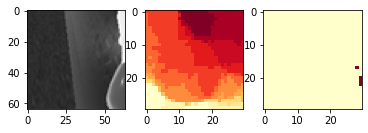

In [88]:
sample_n = 50
plotSom(test_topCamP, sample_n, top_visual_som_5)

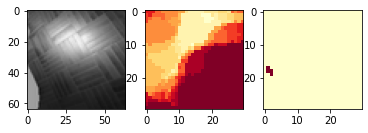

In [89]:
plotSom(test_botCamP, sample_n, bottom_visual_som_5)

### Test

#### Recreate joint data from bottom visual data

Joints from bottom camera data
mse: 0.11397012478502914
std: 0.07900839532324772


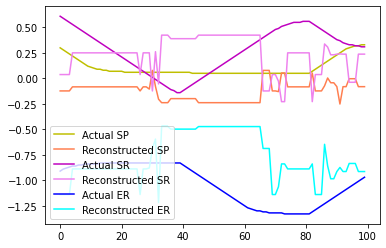

In [90]:
out_51, mse_mean_51, mse_std_51 = testSomHubPass(bottom_visual_som_5, hub_som_5, proprio_som_5, 2, 0, 3, hebbian_network_5, N_test, test_botCam, test_joints)
print('Joints from bottom camera data')
print('mse:', mse_mean_51)
print('std:', mse_std_51)
plotJoints(test_joints, out_51)

#### Recreate joint data from top visual data

Joints from top camera data
mse: 0.04980495661452613
std: 0.026121912193358153


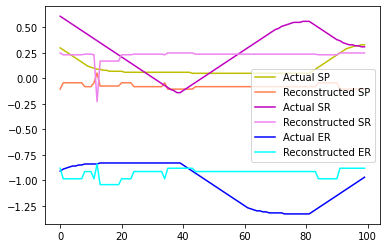

In [91]:
out_52, mse_mean_52, mse_std_52 = testSomHubPass(top_visual_som_5, hub_som_5, proprio_som_5, 1, 0, 3, hebbian_network_5, N_test, test_topCam, test_joints)
print('Joints from top camera data')
print('mse:', mse_mean_52)
print('std:', mse_std_52)
plotJoints(test_joints, out_52)

#### Recreate bottom visual data from joint data

In [92]:
out_53, mse_mean_53, mse_std_53 = testSomHubPass(proprio_som_5, hub_som_5, bottom_visual_som_5, 3, 0, 2, hebbian_network_5, N_test, test_joints, test_botCam)
print('bottom camera data from joints')
print('mse:', mse_mean_53)
print('std:', mse_std_53)

bottom camera data from joints
mse: 1207.0336119771716
std: 872.2968783053301


Visualisation

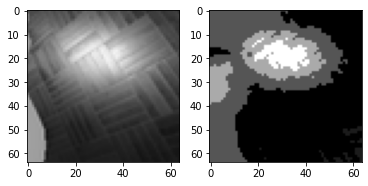

In [93]:
sampleNummer=50
out_53 = denorm(out_53)
plotVisual(test_botCamP, out_53, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from joint data

In [94]:
out_54, mse_mean_54, mse_std_54 = testSomHubPass(proprio_som_5, hub_som_5, top_visual_som_5, 3, 0, 1, hebbian_network_5, N_test, test_joints, test_topCam)
print('top camera data from joints')
print('mse:', mse_mean_54)
print('std:', mse_std_54)


top camera data from joints
mse: 1.0844999981413934
std: 0.49526856628891736


Visialisation



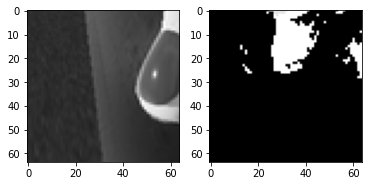

In [96]:
sampleNummer=75
out_54 = out_54*1000
plotVisual(test_topCamP, out_54, sampleNummer)
sampleNummer+=1

#### Recreate top visual data from bottom visual data

In [97]:
out_55, mse_mean_55, mse_std_55 = testSomHubPass(bottom_visual_som_5, hub_som_5,  top_visual_som_5, 2, 0, 1, hebbian_network_5, N_test, test_botCam, test_topCam)
print('top camera data from bottom')
print('mse:', mse_mean_55)
print('std:', mse_std_55)

top camera data from bottom
mse: 1.1922696434769438
std: 0.5657463642687398


Visualisation

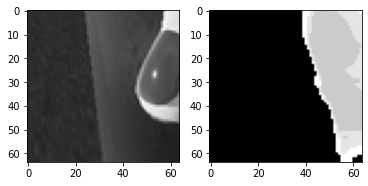

In [98]:
sampleNummer=75
out_55 = out_55*1000
plotVisual(test_topCamP, out_55, sampleNummer)
sampleNummer+=1

#### Recreate bottom visual data from top visual data

In [99]:
out_56, mse_mean_56, mse_std_56 = testSomHubPass(top_visual_som_5, hub_som_5,  bottom_visual_som_5, 1, 0, 2, hebbian_network_5, N_test, test_topCam, test_botCam)
print('Joints from top camera data')
print('mse:', mse_mean_56)
print('std:', mse_std_56)


Joints from top camera data
mse: 638.3398338977372
std: 506.3160976856957


Visualisation

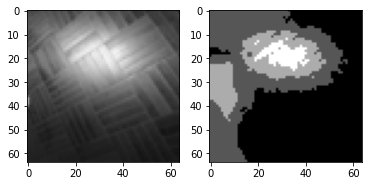

In [100]:
sampleNummer=75
out_56 = denorm(out_56)
plotVisual(test_botCamP, out_56, sampleNummer)
sampleNummer+=1

# Results

In [101]:
import pandas as pd

names = ["proprio_hub", "extra_hub", "extra_concat", "cos_proprio_hub", "cos_extra_hub", "cos_extra_concat" ]
mse_prop_bot = [mse_mean_01, mse_mean_11, mse_mean_21, mse_mean_31, mse_mean_41, mse_mean_51]
mse_prop_top = [mse_mean_02, mse_mean_12, mse_mean_22, mse_mean_32, mse_mean_42, mse_mean_52]
mse_bot_prop = [mse_mean_03, mse_mean_13, mse_mean_23, mse_mean_33, mse_mean_43, mse_mean_53]
mse_top_prop = [mse_mean_04, mse_mean_14, mse_mean_24, mse_mean_34, mse_mean_44, mse_mean_54]
mse_top_bot = [mse_mean_05, mse_mean_15, mse_mean_25, mse_mean_35, mse_mean_45, mse_mean_55]
mse_bot_top = [mse_mean_06, mse_mean_16, mse_mean_26, mse_mean_36, mse_mean_46, mse_mean_56]

mse_prop_bot = [np.round(i,5) for i in mse_prop_bot]
mse_prop_top = [np.round(i,5) for i in mse_prop_top]
mse_bot_prop = [np.round(i,5) for i in mse_bot_prop]
mse_top_prop = [np.round(i,5) for i in mse_top_prop]
mse_top_bot = [np.round(i,5) for i in mse_top_bot]
mse_bot_top = [np.round(i,5) for i in mse_bot_top]

mean_results = {'model_name': names,
        'prop(bot)': mse_prop_bot,
        'prop(top)': mse_prop_top,
        'bot(prop)': mse_bot_prop,
        'top(prop)': mse_top_prop,
        'top(bot)' : mse_top_bot,
        'bot(top)' : mse_bot_top,
        }

mean = pd.DataFrame (mean_results, columns = ['model_name', 'prop(bot)', 'prop(top)', 'bot(prop)', 'top(prop)', 'top(bot)', 'bot(top)' ])

std_prop_bot = [mse_std_01, mse_std_11, mse_std_21, mse_std_31, mse_std_41, mse_std_51]
std_prop_top = [mse_std_02, mse_std_12, mse_std_22, mse_std_32, mse_std_42, mse_std_52]
std_bot_prop = [mse_std_03, mse_std_13, mse_std_23, mse_std_33, mse_std_43, mse_std_53]
std_top_prop = [mse_std_04, mse_std_14, mse_std_24, mse_std_34, mse_std_44, mse_std_54]
std_top_bot = [mse_std_05, mse_std_15, mse_std_25, mse_std_35, mse_std_45, mse_std_55]
std_bot_top = [mse_std_06, mse_std_16, mse_std_26, mse_std_36, mse_std_46, mse_std_56]

std_prop_bot = [np.round(i,5) for i in std_prop_bot]
std_prop_top = [np.round(i,5) for i in std_prop_top]
std_bot_prop = [np.round(i,5) for i in std_bot_prop]
std_top_prop = [np.round(i,5) for i in std_top_prop]
std_top_bot = [np.round(i,5) for i in std_top_bot]
std_bot_top = [np.round(i,5) for i in std_bot_top]

std_results = {'model_name': names,
        'prop(bot)': std_prop_bot,
        'prop(top)': std_prop_top,
        'bot(prop)': std_bot_prop,
        'top(prop)': std_top_prop,
        'top(bot)' : std_top_bot,
        'bot(top)' : std_bot_top,
        }

std = pd.DataFrame (std_results, columns = ['model_name', 'prop(bot)', 'prop(top)', 'bot(prop)', 'top(prop)', 'top(bot)', 'bot(top)' ])

mean.to_csv('mean.csv', sep=',', index=False)
std.to_csv('std.csv', sep=',', index=False)

print("Mean Square Error for all models")
print(mean)
print(" ")
print("Mean Standart Deviation for all models")
print(std)


Mean Square Error for all models
         model_name  prop(bot)  prop(top)  ...  top(prop)  top(bot)    bot(top)
0       proprio_hub    0.20744    0.19913  ...    0.87550   1.02971  1891.31227
1         extra_hub    0.28130    0.23454  ...    0.99962   0.97262  2743.74497
2      extra_concat    0.15267    0.10553  ...    1.01444   1.03164  2041.79401
3   cos_proprio_hub    0.11278    0.07341  ...    1.07134   1.14912   398.63883
4     cos_extra_hub    0.09497    0.09707  ...    0.99691   0.95510     1.93113
5  cos_extra_concat    0.11397    0.04980  ...    1.08450   1.19227   638.33983

[6 rows x 7 columns]
 
Mean Standart Deviation for all models
         model_name  prop(bot)  prop(top)  ...  top(prop)  top(bot)   bot(top)
0       proprio_hub    0.12743    0.14017  ...    0.31220   0.42772    0.14133
1         extra_hub    0.15132    0.15555  ...    0.40928   0.41782  652.49857
2      extra_concat    0.12567    0.06240  ...    0.42867   0.43172  221.17904
3   cos_proprio_hub    0.081

Proprioceptive modality reconstruction from bottom camera


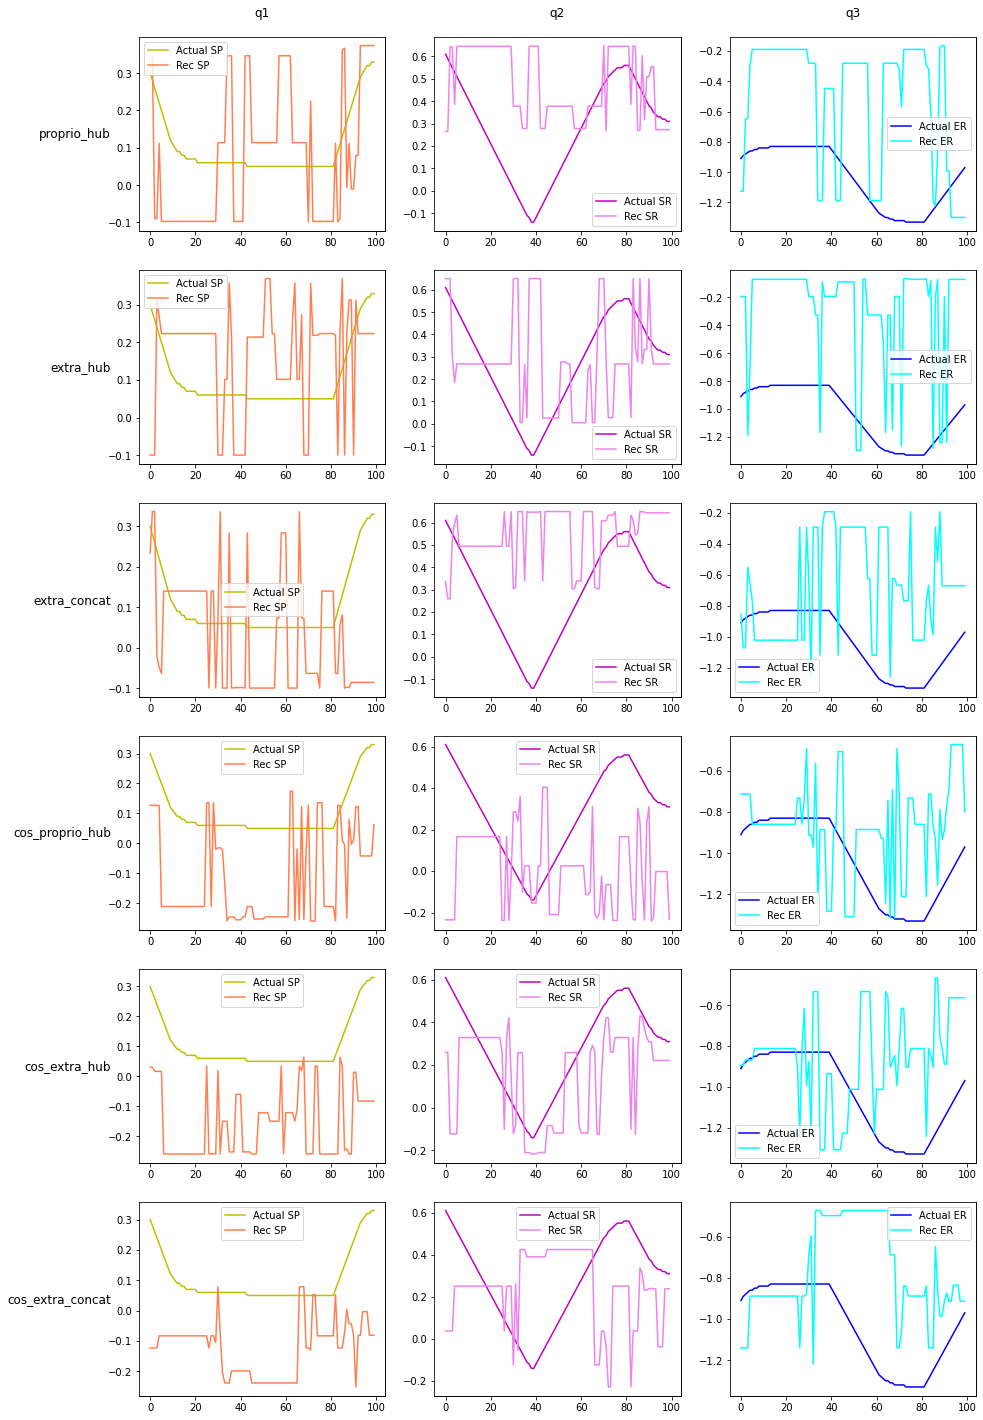

In [102]:

out_proprio_bot = [out_01, out_11, out_21, out_31, out_41, out_51]
out_proprio_top = [out_02, out_12, out_22, out_32, out_42, out_52]

print("Proprioceptive modality reconstruction from bottom camera")
i=0
f, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 25))

rows = ["proprio_hub", "extra_hub", "extra_concat", "cos_proprio_hub", "cos_extra_hub", "cos_extra_concat"]
cols = ['q1', 'q2', 'q3']

pad = 20
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
for j in range(6):
    reals = test_joints
    outputs = np.array(out_proprio_bot[j])
    real_SP, real_SR, real_ER = reals[:,0], reals[:,1], reals[:,2]
    recon_SP, recon_SR, recon_ER = outputs[:,0], outputs[:,1], outputs[:,2]

    f.add_subplot(6, 3, i+1)   
    plt.plot(real_SP, 'y', label="Actual SP")
    plt.plot(recon_SP, color='coral', label="Rec SP")
    plt.legend()


    f.add_subplot(6, 3, i+2)
    plt.plot(real_SR, 'm', label="Actual SR")
    plt.plot(recon_SR, color='violet', label="Rec SR")
    plt.legend()


    f.add_subplot(6, 3, i+3)
    plt.plot(real_ER, 'b', label="Actual ER")
    plt.plot(recon_ER, color='cyan', label="Rec ER")
    plt.legend()
    i = i+3

plt.show(block=True) 

Proprioceptive modality reconstruction from top camera


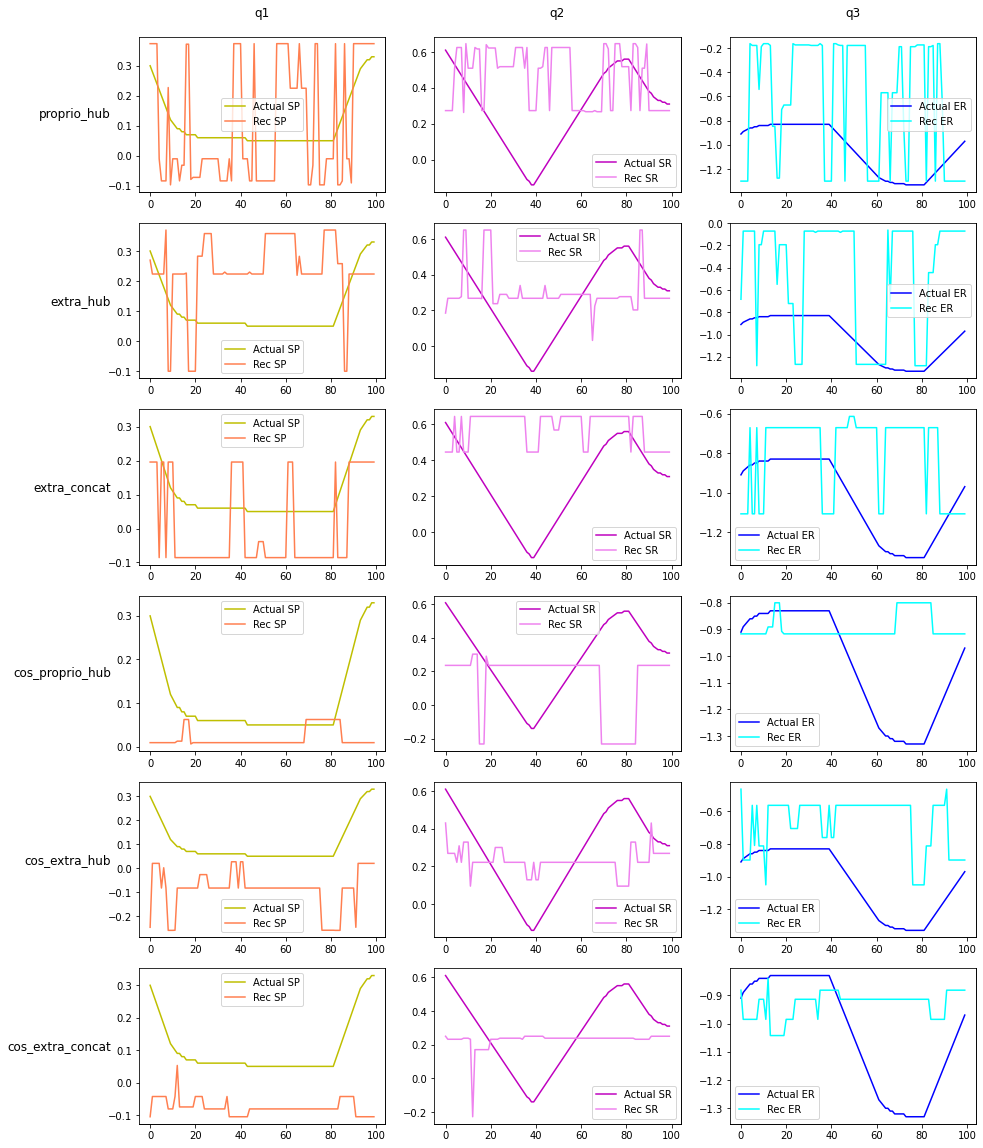

In [103]:
out_proprio_bot = [out_01, out_11, out_21, out_31, out_41, out_51]
out_proprio_top = [out_02, out_12, out_22, out_32, out_42, out_52]

print("Proprioceptive modality reconstruction from top camera")
i=0
f, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
rows = ["proprio_hub", "extra_hub", "extra_concat", "cos_proprio_hub", "cos_extra_hub", "cos_extra_concat"]
cols = ['q1', 'q2', 'q3']

pad = 20
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    
for j in range(6):
    reals = test_joints
    outputs = np.array(out_proprio_top[j])
    real_SP, real_SR, real_ER = reals[:,0], reals[:,1], reals[:,2]
    recon_SP, recon_SR, recon_ER = outputs[:,0], outputs[:,1], outputs[:,2]

    f.add_subplot(6, 3, i+1)   
    plt.plot(real_SP, 'y', label="Actual SP")
    plt.plot(recon_SP, color='coral', label="Rec SP")
    plt.legend()


    f.add_subplot(6, 3, i+2)
    plt.plot(real_SR, 'm', label="Actual SR")
    plt.plot(recon_SR, color='violet', label="Rec SR")
    plt.legend()


    f.add_subplot(6, 3, i+3)
    plt.plot(real_ER, 'b', label="Actual ER")
    plt.plot(recon_ER, color='cyan', label="Rec ER")
    plt.legend()

    i = i+3

Visual modality reconstruction


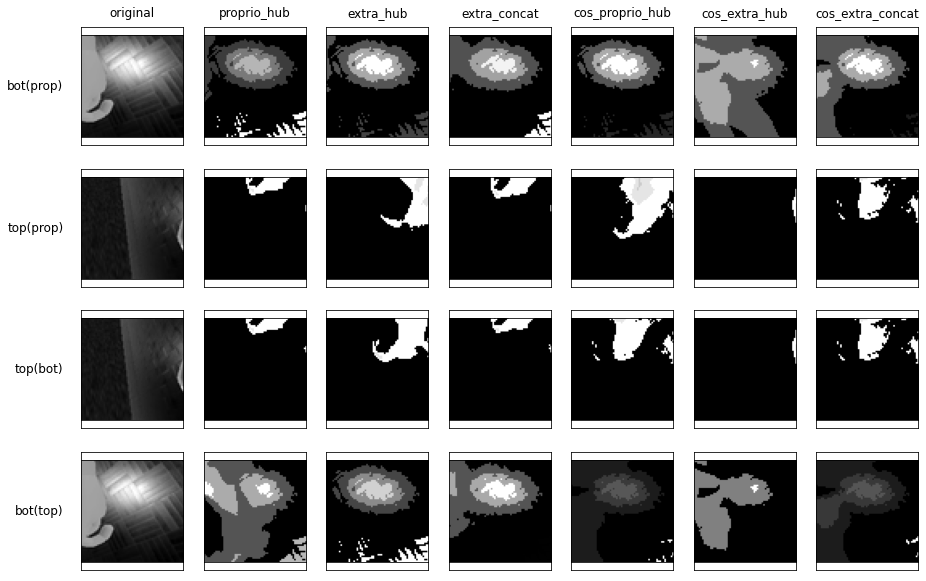

In [106]:
s_n = 90 # choose sample number to show or replay to show next sample

im_bot_proprio = [test_botCamP[s_n], out_03[s_n], out_13[s_n], out_23[s_n], out_33[s_n], out_43[s_n], out_53[s_n]]
im_top_proprio = [test_topCamP[s_n], out_04[s_n], out_14[s_n], out_24[s_n], out_34[s_n], out_44[s_n], out_54[s_n]]
im_top_bot = [test_topCamP[s_n], out_05[s_n], out_15[s_n], out_25[s_n], out_35[s_n], out_45[s_n], out_55[s_n]]
im_bot_top = [test_botCamP[s_n], out_06[s_n], out_16[s_n], out_26[s_n], out_36[s_n], out_46[s_n], out_56[s_n]]
imgs = [im_bot_proprio, im_top_proprio, im_top_bot, im_bot_top]

print("Visual modality reconstruction")
cols = ["original", "proprio_hub", "extra_hub", "extra_concat", "cos_proprio_hub", "cos_extra_hub", "cos_extra_concat"]
rows = ['bot(prop)', 'top(prop)', 'top(bot)', 'bot(top)']

f, axes = plt.subplots(nrows=4, ncols=7, figsize=(15, 10))
pad = 10
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

n=1
for i in range(4):
  for j in range(7):   
    im = np.array(imgs[i][j])
    im = im.astype(np.uint8)
    im = Image.fromarray(im.reshape(64, 64))
    f.add_subplot(4, 7, n)
    n=n+1
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.imshow(im, cmap='gray')